In [10]:
!pip install aif360

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix



In [6]:
# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("colorblind")
print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [7]:
def load_compas_data():
    """Load and preprocess COMPAS dataset following ProPublica's methodology"""
    print("📥 Loading COMPAS dataset...")

    try:
        # Load from ProPublica's GitHub
        url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
        df = pd.read_csv(url)
        print(f"✅ Dataset loaded with {len(df)} rows")

        # Apply ProPublica's filtering criteria
        print("🔍 Applying ProPublica's filtering criteria...")
        df = df[(df['days_b_screening_arrest'] <= 30) &
               (df['days_b_screening_arrest'] >= -30)]
        df = df[df['is_recid'] != -1]
        df = df[df['c_charge_degree'] != 'O']
        df = df[df['score_text'] != 'N/A']

        print(f"✅ Filtered dataset: {len(df)} rows remaining")

        # Create binary outcome variable
        df['recidivist'] = df['two_year_recid']

        # Focus on African-American vs Caucasian defendants (main comparison)
        df = df[df['race'].isin(['African-American', 'Caucasian'])]

        # Create privileged/unprivileged groups
        df['privileged'] = (df['race'] == 'Caucasian').astype(int)

        print("📊 Dataset overview:")
        print(f"   - African-American defendants: {len(df[df['race'] == 'African-American'])}")
        print(f"   - Caucasian defendants: {len(df[df['race'] == 'Caucasian'])}")
        print(f"   - Recidivism rate: {df['recidivist'].mean():.2%}")

        return df

    except Exception as e:
        print(f"❌ Error loading data: {e}")
        return None

# Load the data
df = load_compas_data()
df.head()

📥 Loading COMPAS dataset...
✅ Dataset loaded with 7214 rows
🔍 Applying ProPublica's filtering criteria...
✅ Filtered dataset: 6172 rows remaining
📊 Dataset overview:
   - African-American defendants: 3175
   - Caucasian defendants: 2103
   - Recidivism rate: 47.04%


,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid,recidivist,privileged
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1,1,0
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1,1,0
6,8,edward riddle,edward,riddle,2014-02-19,Male,1974-07-23,41,25 - 45,Caucasian,...,2014-02-19,2014-03-31,2014-04-18,14,5,40,1,1,1,1
8,10,elizabeth thieme,elizabeth,thieme,2014-03-16,Female,1976-06-03,39,25 - 45,Caucasian,...,2014-03-16,2014-03-15,2014-03-18,0,2,747,0,0,0,1
10,14,benjamin franc,benjamin,franc,2013-11-26,Male,1988-06-01,27,25 - 45,Caucasian,...,2013-11-26,2013-11-25,2013-11-26,0,0,857,0,0,0,1


In [8]:
def initial_bias_analysis(df):
    """Perform initial bias analysis on the dataset"""
    print("\n🔍 Performing initial bias analysis...")

    # Basic demographic analysis
    race_counts = df['race'].value_counts()
    recidivism_by_race = df.groupby('race')['recidivist'].mean()

    print("📈 Recidivism by Race:")
    for race in recidivism_by_race.index:
        print(f"   - {race}: {recidivism_by_race[race]:.2%}")

    # COMPAS score analysis
    print("\n🎯 COMPAS Score Distribution by Race:")
    score_by_race = df.groupby('race')['decile_score'].mean()
    for race in score_by_race.index:
        print(f"   - {race} average score: {score_by_race[race]:.1f}")

    return race_counts, recidivism_by_race

race_counts, recidivism_by_race = initial_bias_analysis(df)


🔍 Performing initial bias analysis...
📈 Recidivism by Race:
   - African-American: 52.31%
   - Caucasian: 39.09%

🎯 COMPAS Score Distribution by Race:
   - African-American average score: 5.3
   - Caucasian average score: 3.6


In [12]:
def prepare_aif360_dataset(df):
    """Prepare data for AI Fairness 360 toolkit"""
    print("\n🛠️ Preparing data for AIF360...")

    # Select features for analysis
    features = ['age', 'priors_count', 'c_charge_degree', 'sex']
    X = pd.get_dummies(df[features], drop_first=True)
    y = df['recidivist']

    # The 'privileged' column needs to be part of the DataFrame passed to BinaryLabelDataset
    # Create a Series for the protected attribute, ensuring it has a name
    protected_attribute_col = df['privileged'].rename('privileged')

    # Combine X, y, and the protected attribute column for the AIF360 dataset
    aif_df = pd.concat([X, y, protected_attribute_col], axis=1)

    # Create AIF360 dataset
    dataset = BinaryLabelDataset(
        df=aif_df, # Pass the combined DataFrame
        label_names=['recidivist'],
        protected_attribute_names=['privileged'],
        favorable_label=0,  # No recidivism is favorable
        unfavorable_label=1,  # Recidivism is unfavorable
        # Specify unprivileged and privileged groups based on the 'privileged' column (0 for African-American, 1 for Caucasian)
        unprivileged_protected_attributes=[[0]],
        privileged_protected_attributes=[[1]]
    )

    print("✅ AIF360 dataset prepared")
    # Return protected_attribute_col.values if you need the numpy array of the protected attribute separately
    return dataset, X, y, protected_attribute_col.values

In [19]:
dataset, X, y, protected_attribute_values = prepare_aif360_dataset(df)


🛠️ Preparing data for AIF360...
✅ AIF360 dataset prepared


In [16]:
def calculate_bias_metrics(dataset):
    """Calculate comprehensive bias metrics using AIF360"""
    print("\n📊 Calculating Bias Metrics...")

    # Define privileged group (Caucasian)
    privileged_groups = [{'privileged': 1}]
    unprivileged_groups = [{'privileged': 0}]

    # Calculate dataset metrics
    metric = BinaryLabelDatasetMetric(
        dataset,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups
    )

    print("📈 Statistical Parity Difference:")
    print(f"   - Mean Difference: {metric.mean_difference():.4f}")
    print(f"   - Disparate Impact: {metric.disparate_impact():.4f}")

    print("\n🔍 Base Rates:")
    print(f"   - Unprivileged group base rate: {metric.base_rate(privileged=False):.4f}")
    print(f"   - Privileged group base rate: {metric.base_rate(privileged=True):.4f}")

    return metric, privileged_groups, unprivileged_groups

# Calculate initial bias metrics
metric, privileged_groups, unprivileged_groups = calculate_bias_metrics(dataset)


📊 Calculating Bias Metrics...
📈 Statistical Parity Difference:
   - Mean Difference: -0.1323
   - Disparate Impact: 0.7828

🔍 Base Rates:
   - Unprivileged group base rate: 0.4769
   - Privileged group base rate: 0.6091


In [21]:
def train_model_and_analyze(X, y, protected_attribute):
    """Train a model and analyze bias in predictions"""
    print("\n🤖 Training Model and Analyzing Predictions...")

    # Split the data
    X_train, X_test, y_train, y_test, prot_train, prot_test = train_test_split(
        X, y, protected_attribute, test_size=0.3, random_state=42, stratify=y
    )

    # Train logistic regression model
    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Create datasets for AIF360 metrics
    # Ensure 'privileged' column is present for AIF360
    prot_test_series = pd.Series(prot_test, index=X_test.index, name='privileged')
    combined_test_df = pd.concat([X_test, y_test, prot_test_series], axis=1)

    dataset_test = BinaryLabelDataset(
        df=combined_test_df, # Pass the combined DataFrame including 'privileged'
        label_names=['recidivist'],
        protected_attribute_names=['privileged'],
        favorable_label=0,
        unfavorable_label=1,
        unprivileged_protected_attributes=[[0]],
        privileged_protected_attributes=[[1]]
    )

    dataset_pred = dataset_test.copy()
    dataset_pred.labels = y_pred.reshape(-1, 1)

    # Calculate classification metrics
    classified_metric = ClassificationMetric(
        dataset_test, dataset_pred,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups
    )

    print("🎯 Performance Metrics by Group:")
    print(f"   - Accuracy: Overall {accuracy_score(y_test, y_pred):.4f}")
    print(f"   - FPR Difference: {classified_metric.false_positive_rate_difference():.4f}")
    print(f"   - FNR Difference: {classified_metric.false_negative_rate_difference():.4f}")

    print(f"\n📊 False Positive Rates:")
    print(f"   - African-American: {classified_metric.false_positive_rate(privileged=False):.4f}")
    print(f"   - Caucasian: {classified_metric.false_positive_rate(privileged=True):.4f}")

    print(f"\n📊 False Negative Rates:")
    print(f"   - African-American: {classified_metric.false_negative_rate(privileged=False):.4f}")
    print(f"   - Caucasian: {classified_metric.false_negative_rate(privileged=True):.4f}")

    return classified_metric, model, X_test, y_test, prot_test, y_pred

classified_metric, model, X_test, y_test, prot_test, y_pred = train_model_and_analyze(X, y, protected_attribute_values)


🤖 Training Model and Analyzing Predictions...
🎯 Performance Metrics by Group:
   - Accuracy: Overall 0.6705
   - FPR Difference: -0.2919
   - FNR Difference: 0.1344

📊 False Positive Rates:
   - African-American: 0.3185
   - Caucasian: 0.6104

📊 False Negative Rates:
   - African-American: 0.3149
   - Caucasian: 0.1804



📈 Creating Bias Visualizations...


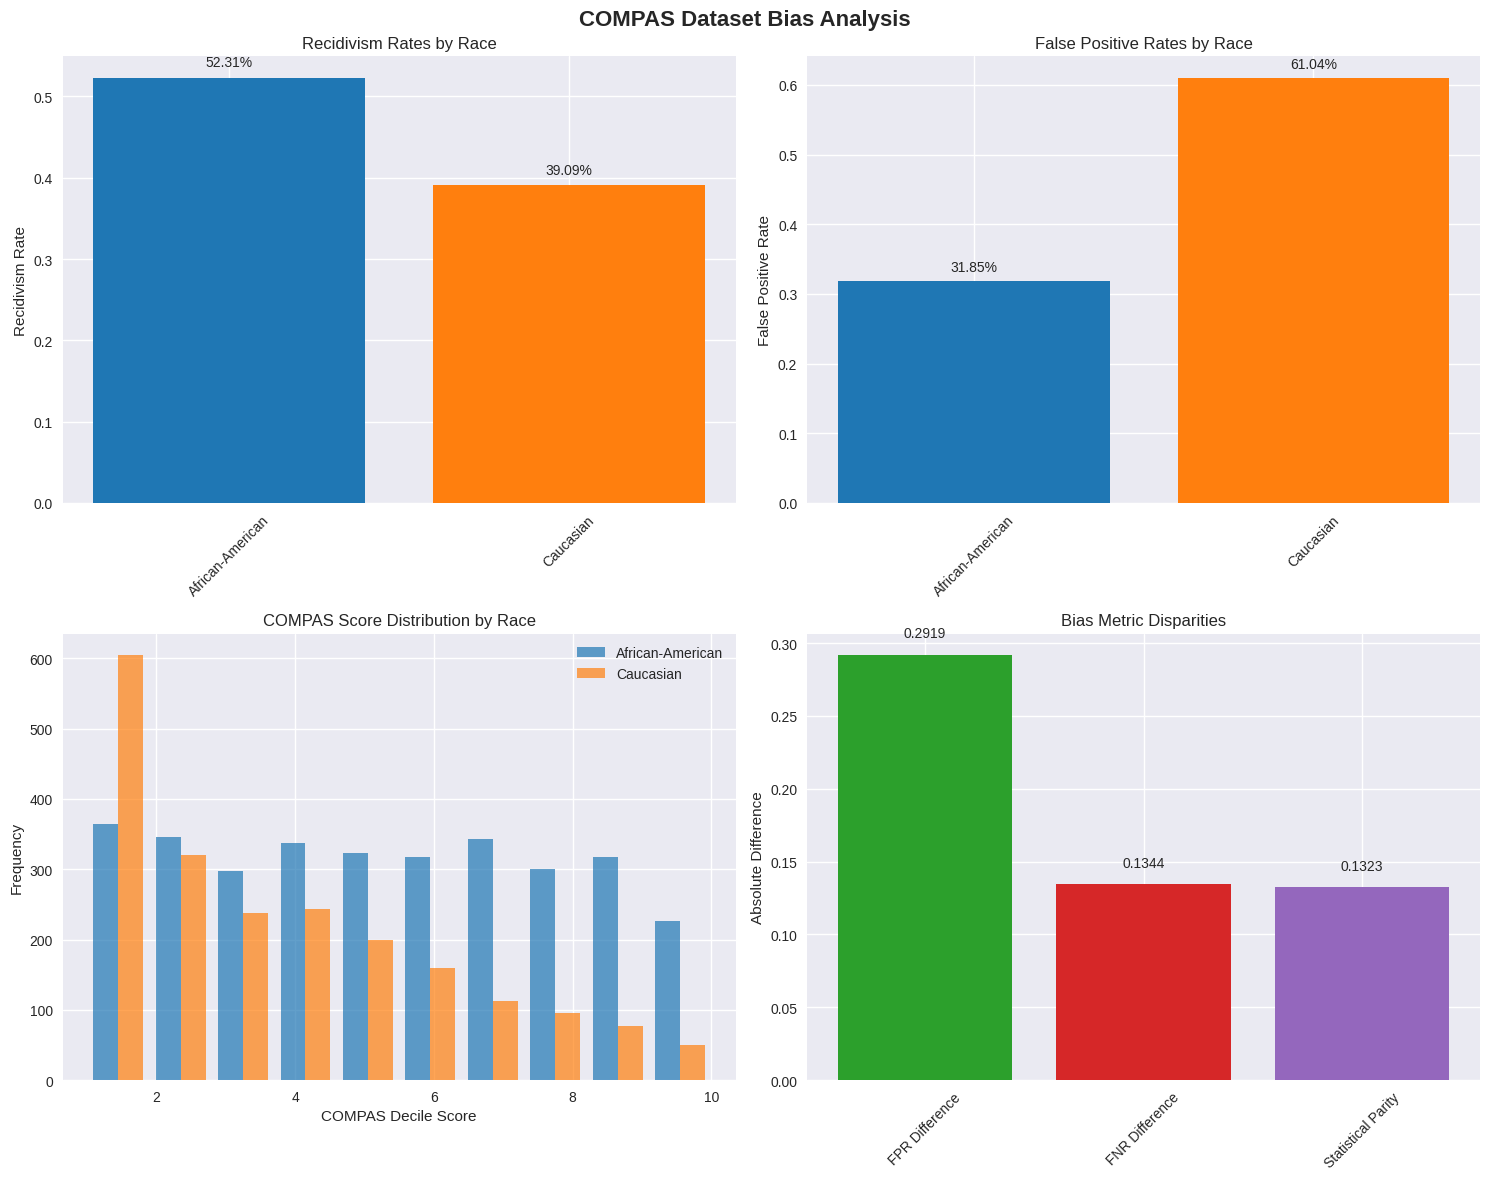

✅ Visualizations saved as 'compas_bias_analysis.png'


In [22]:
def create_bias_visualizations(df, classified_metric, y_test, prot_test, y_pred):
    """Create comprehensive bias visualization charts"""
    print("\n📈 Creating Bias Visualizations...")

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('COMPAS Dataset Bias Analysis', fontsize=16, fontweight='bold')

    # Plot 1: Recidivism Rates by Race
    recidivism_rates = df.groupby('race')['recidivist'].mean()
    axes[0,0].bar(recidivism_rates.index, recidivism_rates.values, color=['#1f77b4', '#ff7f0e'])
    axes[0,0].set_title('Recidivism Rates by Race')
    axes[0,0].set_ylabel('Recidivism Rate')
    axes[0,0].tick_params(axis='x', rotation=45)

    for i, v in enumerate(recidivism_rates.values):
        axes[0,0].text(i, v + 0.01, f'{v:.2%}', ha='center', va='bottom')

    # Plot 2: False Positive Rates by Race
    fpr_data = {
        'African-American': classified_metric.false_positive_rate(privileged=False),
        'Caucasian': classified_metric.false_positive_rate(privileged=True)
    }
    axes[0,1].bar(fpr_data.keys(), fpr_data.values(), color=['#1f77b4', '#ff7f0e'])
    axes[0,1].set_title('False Positive Rates by Race')
    axes[0,1].set_ylabel('False Positive Rate')
    axes[0,1].tick_params(axis='x', rotation=45)

    for i, v in enumerate(fpr_data.values()):
        axes[0,1].text(i, v + 0.01, f'{v:.2%}', ha='center', va='bottom')

    # Plot 3: COMPAS Score Distribution
    aa_scores = df[df['race'] == 'African-American']['decile_score']
    cauc_scores = df[df['race'] == 'Caucasian']['decile_score']

    axes[1,0].hist([aa_scores, cauc_scores], bins=10, alpha=0.7,
                   label=['African-American', 'Caucasian'], color=['#1f77b4', '#ff7f0e'])
    axes[1,0].set_title('COMPAS Score Distribution by Race')
    axes[1,0].set_xlabel('COMPAS Decile Score')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].legend()

    # Plot 4: Error Rate Disparities
    error_metrics = {
        'FPR Difference': abs(classified_metric.false_positive_rate_difference()),
        'FNR Difference': abs(classified_metric.false_negative_rate_difference()),
        'Statistical Parity': abs(metric.mean_difference())
    }

    axes[1,1].bar(error_metrics.keys(), error_metrics.values(), color=['#2ca02c', '#d62728', '#9467bd'])
    axes[1,1].set_title('Bias Metric Disparities')
    axes[1,1].set_ylabel('Absolute Difference')
    axes[1,1].tick_params(axis='x', rotation=45)

    for i, v in enumerate(error_metrics.values()):
        axes[1,1].text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig('compas_bias_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✅ Visualizations saved as 'compas_bias_analysis.png'")

create_bias_visualizations(df, classified_metric, y_test, prot_test, y_pred)

In [25]:
def apply_bias_mitigation(dataset):
    """Apply reweighing pre-processing to mitigate bias"""
    print("\n⚖️ Applying Bias Mitigation (Reweighing)...")

    # Split dataset
    dataset_train, dataset_test = dataset.split([0.7], shuffle=True, seed=42)

    # Apply reweighing
    RW = Reweighing(unprivileged_groups=unprivileged_groups,
                   privileged_groups=privileged_groups)
    dataset_transformed = RW.fit_transform(dataset_train)

    # Calculate metrics after reweighing
    metric_transformed = BinaryLabelDatasetMetric(
        dataset_transformed,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups
    )

    print("📊 Before vs After Reweighing:")
    print(f"   - Statistical Parity Difference:")
    print(f"     Before: {metric.mean_difference():.4f}")
    print(f"     After:  {metric_transformed.mean_difference():.4f}")

    print(f"   - Disparate Impact:")
    print(f"     Before: {metric.disparate_impact():.4f}")
    print(f"     After:  {metric_transformed.disparate_impact():.4f}")

    improvement = abs(metric.mean_difference()) - abs(metric_transformed.mean_difference())
    print(f"   - Improvement in fairness: {improvement:.4f}")

    return dataset_transformed, metric_transformed

dataset_transformed, metric_transformed = apply_bias_mitigation(dataset)


⚖️ Applying Bias Mitigation (Reweighing)...
📊 Before vs After Reweighing:
   - Statistical Parity Difference:
     Before: -0.1323
     After:  0.0000
   - Disparate Impact:
     Before: 0.7828
     After:  1.0000
   - Improvement in fairness: 0.1323
